# 1. Simulate the data

This notebook contains the code to simulate the data for the experiments. 

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import linalg
from sklearn.metrics import r2_score

In [2]:
# load the settings that we store externally
config = json.load(open('settings.json'))
N_responses = config['N_responses']
rater_rhos = config['rater_rhos']
n_raters = config['n_raters']
n_systems = config['n_systems']
score_range = config['score_range']

In [3]:
# We first generate true score with a given distribution
# We also truncate it to score range.
np.random.seed(100)
true_scores = np.random.normal(config['true_score_mean'], config['true_score_sd'], N_responses)
true_scores = np.where(true_scores >= score_range[1], score_range[1],
                      np.where(true_scores <= score_range[0], score_range[0],
                      true_scores))

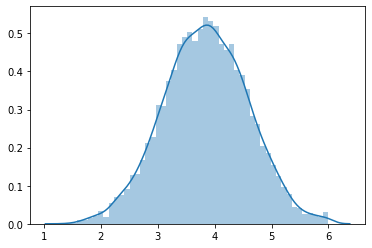

In [4]:
sns.distplot(true_scores)

We are going to empirically figure out what sort of error give us an expected correlation.

In [5]:
def get_rater_score(true_score, error, seed):
    '''
    Compute rater score using true scores and errror
    '''
    np.random.seed(seed)
    rater_error = np.random.normal(0, error, N_responses)
    rater_round = rater = np.round(true_score + rater_error)
    rater_truncated = pd.Series(np.where(rater > score_range[1], score_range[1],
                                np.where(rater < score_range[0], score_range[0],
                                rater)))
    return rater_truncated

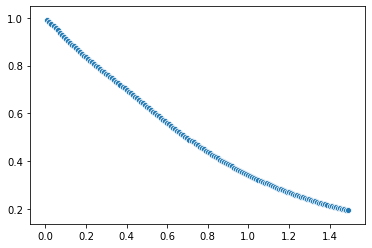

In [6]:
# Look at relationship between the error we add and the correlation between raters
corrs = []
errors = np.arange(0.01, 1.5, step=0.01)
seed = 100
for error in errors:
    raters = []
    for i in range(0, 50):
        rater = get_rater_score(true_scores, error, seed + i*25)
        raters.append(rater)
    df_raters = pd.concat(raters, axis=1)
    corr_error = df_raters.corr().values
    mean_corr = corr_error[corr_error != 1].mean()
    corrs.append(mean_corr)
sns.scatterplot(x=errors, y=corrs)   

In [7]:
# now get the error corresponding to the desired rho in our configuration file
human_errors = []
for rho in rater_rhos:
    i = (np.abs(np.array(corrs)-rho)).argmin()
    error = errors[i]
    print("Expected inter-rater rho: {}, simulated rho: {}, Error: {}".format(rho, corrs[i], error))
    human_errors.append(error)

Expected inter-rater rho: 0.4, simulated rho: 0.4016214794913189, Error: 0.87
Expected inter-rater rho: 0.55, simulated rho: 0.546943780912957, Error: 0.62
Expected inter-rater rho: 0.6, simulated rho: 0.6004977254030631, Error: 0.54
Expected inter-rater rho: 0.8, simulated rho: 0.7991382675357793, Error: 0.25


In [10]:
### Now simulate the data we will use for our experiments

df = pd.DataFrame({'id': ['id_{}'.format(i) for i in range(N_responses)],
                  'true': true_scores})

# First simulate the human raters
raters = []
rater_index = 1

seed = 232626
for i in range(len(n_raters)):
    error = human_errors[i]
    for j in range(0, n_raters[i]):
        rater_name = 'h_{}'.format(rater_index)
        rater_scores = get_rater_score(true_scores, error, seed + j*23532)
        df[rater_name] = rater_scores
        df_rater = pd.DataFrame({'rater_id': [rater_name],
                                'error': error,
                                'category': config['rater_categories'][i],
                                'expected_rho': config['rater_rhos'][i]})
        raters.append(df_rater)
        rater_index +=1

df_raters = pd.concat(raters)

### Then simulate systems

systems = []
system_index = 1

seed = 726262
for i in range(0, len(n_systems)):
    system_r2 = config['system_r2'][i]
    error = np.sqrt(np.var(true_scores) * (1 - system_r2))
    for j in range(0, n_systems[i]):
        system_name = 'sys_{}'.format(system_index) 
        np.random.seed(seed + j*3426)
        system_error = np.random.normal(0, error, N_responses)
        df[system_name] = true_scores + system_error
        df_system = pd.DataFrame({'system_id': [system_name],
                                  'exp_r2_true': config['system_r2'][i]})
        systems.append(df_system)
        system_index += 1

df_systems = pd.concat(systems)

# Check human score correlations

In [11]:
human_scores = df_raters['rater_id'].values

In [12]:
human_corr = df[human_scores].corr().unstack().reset_index()
human_corr.columns = ['r1', 'r2', 'corr']
# exclude correlation between the scores from the same rater
human_corr = human_corr[human_corr['r1'] != human_corr['r2']]
df_with_category = pd.merge(human_corr, df_raters, left_on ='r1', right_on='rater_id')
df_with_category = pd.merge(df_with_category, df_raters, left_on='r2', right_on='rater_id', 
                           suffixes = ['_r1', '_r2'])
df_with_category['same_group'] = np.where(df_with_category['category_r1'] == df_with_category['category_r2'],
                                         'yes', 'no')
print(rater_rhos)
df_with_category.groupby(['category_r1', 'category_r2'])['corr'].mean().unstack().loc[config['rater_categories'],
                                                                                      config['rater_categories']]

[0.4, 0.55, 0.6, 0.8]


category_r2,low,moderate,average,high
category_r1,,,,
low,0.394381,0.470978,0.492639,0.562844
moderate,0.470978,0.540528,0.575062,0.657783
average,0.492639,0.575062,0.594850,0.689782
high,0.562844,0.657783,0.689782,0.797603


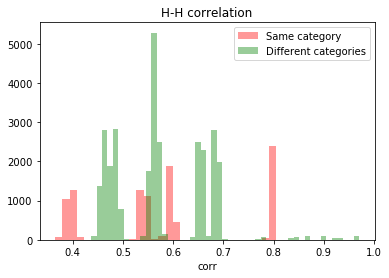

In [13]:
sns.distplot(df_with_category[df_with_category['same_group']=='yes']['corr'],
            color="red", label="Same category", kde=False)
sns.distplot(df_with_category[df_with_category['same_group']=='no']['corr'],
            color="green", label="Different categories", kde=False)
plt.title("H-H correlation")
plt.legend()

## Now look at system scores

In [14]:
df_system_corr = df.corr().unstack().reset_index()
df_system_corr.columns = ['system', 'reference', 'corr']
df_system_corr = df_system_corr[df_system_corr['system'].isin(df_systems['system_id'])]

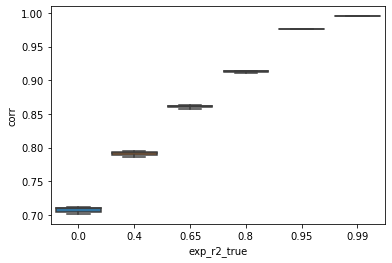

In [15]:
# correlation with true score
df_system_true = df_system_corr[df_system_corr['reference']=='true']
df_true_with_cat = pd.merge(df_system_true, df_systems, left_on='system', right_on='system_id')
sns.boxplot(x='exp_r2_true', y='corr', data=df_true_with_cat)

In [16]:
df_system_corr_with_category = pd.merge(df_system_corr, df_raters, left_on='reference', right_on='rater_id')
df_sys_human = pd.merge(df_system_corr_with_category, df_systems, left_on='system', right_on='system_id')
df_sys_human.groupby(['category', 'exp_r2_true'])['corr'].mean().unstack().loc[config['rater_categories']]

exp_r2_true,0.00,0.40,0.65,0.80,0.95,0.99
category,,,,,,
low,0.444385,0.496658,0.540538,0.573209,0.612636,0.624600
moderate,0.520375,0.581601,0.632997,0.671267,0.717456,0.731476
average,0.546056,0.610274,0.664178,0.704311,0.752737,0.767426
high,0.629892,0.703981,0.766173,0.812477,0.868355,0.885310


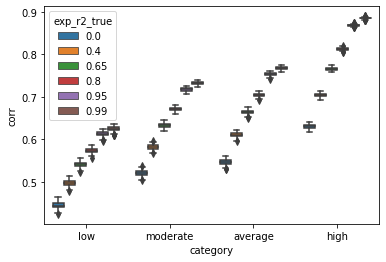

In [17]:
sns.boxplot(x='category', y='corr', hue='exp_r2_true', data=df_sys_human)

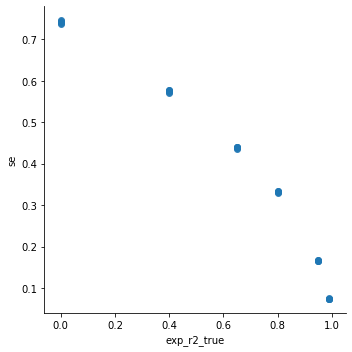

In [18]:
# rmse with true score
df_long = df.melt(id_vars = ['true'],
                 value_vars = df_systems['system_id'].values,
                 var_name = 'system_id',
                 value_name = 'score')
df_long['se'] = (df_long['score'] - df_long['true'])**2
df_by_system = df_long.groupby('system_id')['se'].apply(lambda x: np.sqrt(np.mean(x))).reset_index()
df_long_with_mse = pd.merge(df_by_system, df_systems)
sns.lmplot(x='exp_r2_true', y='se', data=df_long_with_mse, fit_reg=False)

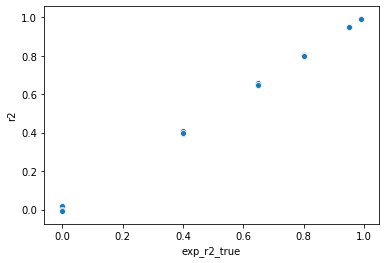

In [19]:
# r2 with true score
df_r2 = df_long.groupby('system_id').apply(lambda x: r2_score(x['true'], x['score'])).reset_index()
df_r2.columns = ['system_id', 'r2']
df_r2_with_mse = pd.merge(df_r2, df_systems)
sns.scatterplot(x='exp_r2_true', y='r2', data=df_r2_with_mse)

In [20]:
df.to_csv('../data/data.csv', index=False)
df_raters.to_csv('../data/raters.csv', index=False)
df_systems.to_csv('../data/systems.csv', index=False)